In [7]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact
from mpl_toolkits.mplot3d import axes3d
#import sys
#!{sys.executable} -m pip install nolds

# Synchronization in Neuronal Dynamics
The goal of this demonstration is to describe the basic mechanisms of neuronal dynamics and how neurons synchronize, as well as explain the significance of synchronization in neuroscience.

## The Biology of Neurons
The firing of action potentials is a fundamental behavior in neurons.  When neurons are in their resting state, a potential difference (around $-70$ mV) is maintained across the cell membrane between the extracellular space and the cytoplasm of the cell, meaning the interior of the neuron is $70$ mV less positive than the exterior of the neuron.  This potential difference is due to a relatively large collection of potassium ions (K$^{+}$) inside the cell and a relatively large collection of sodium ions (Na$^{+}$) outside the cell.  There are other charged objects, such as calcium (Ca$^{2+}$) both inside and outside the neuron, as well as large negative molecules inside the neuron which contribute to this potential difference.  However, sodium and potassium play a primary role in this potential and the firing of action potentials.  The following is a diagram of a neuron.


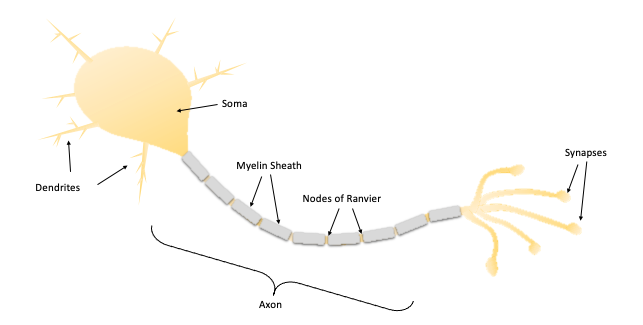

The dendrites are what initiate the action potential.  They're connected to the synapses of other neurons and receive signals which cause the potential difference across the cell to decrease, that is, the relative charge inside the neuron becomes more positive.  If the potential difference reaches a threshold value (usually around $-50$ mV) then the neuron fires an action potential, a large voltage jump across the cell membrane, which travels down the axon to the synapses and can send signals to the dendrite of other neurons, thus repeating the process.  Action potentials last for a very brief period, on the scale of milliseconds, and the potential difference across the membrane can reach $+30$ mV, a $100$ mV jump from the resting state.

The signals are transmitted from the synapse to the dendrite through neurotransmitters that are released from the synapse following an action potential.  The basic mechanisms of this process are addressed in the following sections.

### The Action Potential
An action potential is a large, rapid depolarization across the cell membrane due to ions traveling in to or out of the cell.  It's typically followed by a brief hyperpolarized period in order to prevent rapid firing before returning to its resting value.  There are various components which lead up to this process, and they are discussed here.

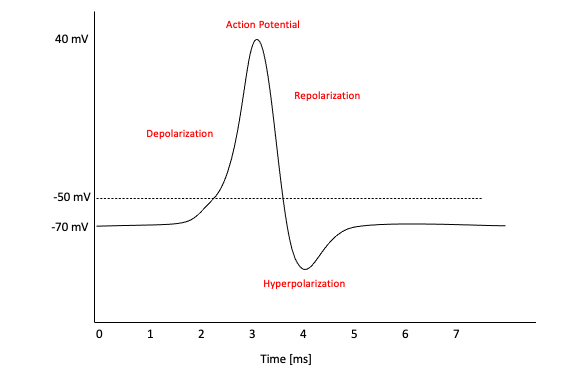

In [8]:
model_three = '''
    // equations 
    V' = -(gCa + rNMDA*aEE*Qv)*mCa*(V-vCa) - (gNa*mNa + aEE*Qv)*(V-vNa) - gK*W*(V-vK) - gL*(V-vL) + aNE*Idelta + aIE*Z*Qz
    Z' = b*(aNI*Idelta + aEI*V*Qv)
    W' = phi*(mK - W)/tau

//8
    // parameters 
    vCa = 1.0 ; // 1.0 // nerst potentials
    vNa = 0.53 ; // 0.53
    vL = -0.5 ; // -0.5
    vK = -0.7 ; // -0.7
    gCa = 1.1 ; // 1.1 // conductances
    gNa = 6.7 ; // 6.7
    gK = 2.0 ; // 2.0
    gL = 0.5 ; // 0.5
    deltaCa = 0.15 ;  // 0.15 // threshold variances
    deltaNa = 0.15 ; // 0.15
    deltaK = 0.3 ; // 0.3
    tCa = -0.01; // -0.01 // threshold potentials
    tNa = 0.3; // 0.3
    tK = 0.0; // 0.0
    mCa := 0.5*(1 + tanh((V-tCa)/deltaCa)) ; // channel activations
    mNa := 0.5*(1 + tanh((V-tNa)/deltaNa)) ;
    mK := 0.5*(1 + tanh((V-tK)/deltaK)) ;
    dV = 0.56 ; // threshold variances
    dZ = 0.7 ; // 0.7
    vT = 0.0 ; // 0.0 // threshold potentials
    zT = 0.0 ; // 0.0
    QvMax = 50.0 ; // max firing rates (guess)
    QzMax = 0.90 ;
    Qv := 0.5*QvMax*(1 + tanh((V-vT)/dV)) ; // firing rate functions
    Qz := 0.5*QzMax*(1 + tanh((V-zT)/dZ)) ; 
    aEE = 0.4 ; //0.4 synaptic strength parameters
    aEI = 0.2 ; //2.0 // 0.31 gives limit cycle
    aIE = 1.0 ; //2.0
    aNE = 1.0 ; // 1.0
    aNI = 0.4 ; // 0.4
    phi = 0.7 ; // 0.7 // scaling factor
    b = -0.1 ; // 0.1 // scaling factor
    Idelta = 0.3 ; // 0.3 // input current
    tau = 1.0 ; // 1.0 // time constant
    rNMDA = 0.25 ; // 0.25 // NMDA:AMPA receptors

    // initial conditions
    V = 0.0 ; 
    Z = 0.08 ;
    W = 0.0 ;
'''

In [4]:
m = te.loada(model_three)
m.vT = 0.54
m.Idelta = 0.32
s = m.simulate(0,3000,3000,['time','V'])
#plt.plot(s['time'],s['V'],label='V')
#plt.plot(s['time'][1410:2500],s['V'][1410:2500],label='potential V')
#plt.xlabel('time')
#plt.ylabel('potential difference across cell membrane')
#plt.title('action potential')
#plt.legend()
#plt.show()

#### Ion Channels
How do signals received by the dendrites cause this potential change?  The answer has to do with transmembrane proteins that transport ions through the membrane.  These proteins, known as ion channels, vary widely in function. They can be selective to certain ions, and can be activated by different mechanisms.  Some ion channels known as ligand-gated channels are activated by ligand-binding; that is, small molecules can bind to the protein and cause it to change shape which allows ions to pass through.  Other ion channels known as voltage-gated channels can be activated by voltage changes.  This latter type is primarily responsible for carrying the action potential along the axon.  The following image depicts the various types of ion channels.  Although the channels here are primarly transporting sodium ions, these channels exist for the other ions being considered as well.  These channels are typically ion-specifice, meaning potassium channels aren't permeable to sodium, and vice versa.  As you can see, some channels are always open, meaning ions are allowed to travel across the membrane at the resting potential.  However, this artifact turns out to be negligible for reasons now to be addressed.

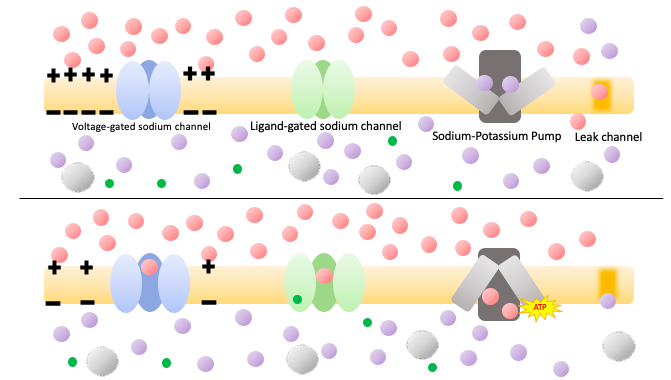
Here, the purple circles are potassium ions $K^{+}$, the red circles are sodium ions $Na^{+}$, the green circles are ligands which bind to the proteins, and the white circles are large negative proteins.

#### Driving Forces
So now that these ions have a mode of transportation across the neuron's membrane, what causes them to move?  One mechanism is of course the electric field that arises from the potential difference.  This causes the positive sodium ions to want to enter the neuron.  However, there must also be something causing the positive potassium ions to leave the neuron.  This additional driving force may be explained by Fick's Law of diffusion, which relates the diffusion flux to the concentration gradient.  While this is a result of thermodynamics and entropy maximization, a simple example of this law may be observed in the process of dropping food coloring in a glass of water.  The food coloring doesn't remain in a small, highly concentrated drop, but rather diffuses, or spreads throughout the water.  According to Fick's law, the large concentration potassium ions inside the neuron would like to diffuse out of the neuron in order to become less concentrated.  Similarly, sodium ions are highly concentrated in the extracellular space and would like to diffuse in to the neuron.

It was previously mentioned that some ion channels are always open allowing ions to travel across the membrane, but that this variation was not very significant.  This is because at the resting potential, the two driving forces, due to the electric field and chemical gradient, actually balance out so that the net force is zero and the number of ions crossing the membrane due to random motion is very small.

### The Firing of an Action Potential
As discussed previously, when a neuron receive signals through its synapses, these signals cause small voltage increases across the cell membrane as ions cross through the channels.  If the sum of these increases reach the threshold, an action potential fires.  During this period, voltage gated sodium channels open causing an imbalance between the chemical gradient and electric field.  The chemical gradient dominates, and sodium ions enter the neuron.  Voltage-gated channels along the length of the axon open as the potential increases and this depolarization traveling down the axon is known as the action potential.  When it reaches the synapse at the end, voltage-gated calcium channels open causing neurotransmitter to be released into the synaptic cleft, which binds to receptors on the dendrites of another neuron, as can be seen in the image above.  Common neurotransmitter molecules are glutamate in excitatory neurons, or gamma-Aminobutyric acid (GABA) in inhibitory neurons, though numerous neurotransmitters have been found to exist in different types of neurons.

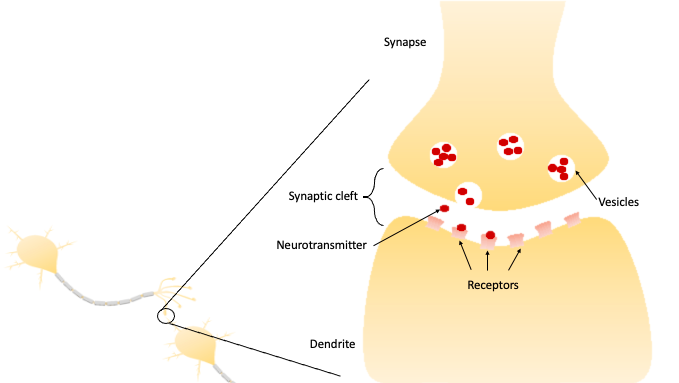

The depolarization isn't long lasting, however.  Once the potential difference across the membrane reaches a certain level, the voltage-gated sodium channels become inactivated.  This means at a certain voltage level (around $20$ mV), the molecular structure of the protein changes again, now blocking ions from passing through the channel.  Potassium channels also open at this point, allowing potassium ions to leave the neuron.  The delay between the opening of sodium and potassium channels is due to their molecular structure, and more information on this can be found in the references.

In addition to the opening of potassium channels, a protein known as the sodium-potassium pump acts as a mechanical pump removing sodium ions from the neuron and bringing potassium ions back in.  This pump is constantly operating regardless of membrane potential, because, as previously mentioned, it is possible for ions to drift across the membrane while a neuron is in its resting state.  The primary driving mechanism of the sodium-potassium pump is the binding of ATP hydrolysis.  However, this is beyond the scope of this application, and more information on the sodium-potassium pump and ATP hydrolysis can be found in the references.

Like the voltage-gated sodium channels, the potassium channels also become inactivated once the membrane potential decreases to a certain level.  The combination of the potassium channels and the sodium-potassium pump repolarize the neuron, bringing it down to a hyperpolarized state, which prevents rapid activation of the sodium channels, before returning to the resting state.  For a more in-depth explanation of the action potential, see the following video presented by the Harvard Extension School: https://www.youtube.com/watch?v=oa6rvUJlg7o

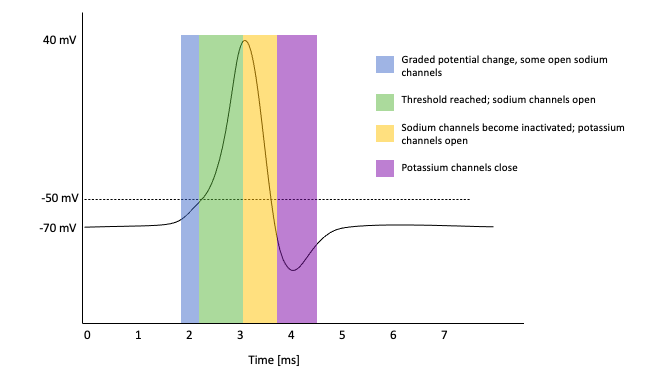

#### Excitatory vs Inhibitory Neurons
Before moving on to the modeling component, it should be addressed that, in broadest terms, there are two types of neurons: excitatory and inhibitory.  Generally speaking, excitatory neurons act by sending signals which cause an action potential to occur (depolarizing signals) while inhibitory neurons send signals that prevent this (hyperpolorizing signals).  A common example of the difference between these neurons is the reflex test in a doctor's office.  When the doctor hits your knee with a rubber hammer, your leg jerks out.  This is due to the sensory neurons connected to the tendon in the knee sending signals to motor neurons.  The motor neurons which cause the quadricep to flex and the neurons which cause the hamstring to flex both receive signals, however, the neurons connected to the hamstring receive inhibitory signals, which prevent those neurons from firing.  This is why you kick outward, rather than pull your leg back, when the doctor hits your knee.

## Modeling an Action Potential
### Constructing a Model
With this basic background on the neuron, how might one go about modeling the behavior of action potentials?  To begin, recall that the inside of the neuron is relatively negative compared to the outside due to charge accumulation of either side.  This means that the membrane may be viewed as a capacitor with positive charge on the side facing the extracellular space and negative charge on the side facing the cytoplasm.  What type of information can be gained from taking this perspective?  Recall that the potential difference is due to ions and that this ions can pass through the membrane.  The rate at which these ions pass through the membrane depends on two factors: the fraction of open channels $m_{ion}$ and the conductance $g_{ion}$ of the channel.  Here $m_{ion}$ should range between $0$ (all channels closed) and $1$ (all channels open).  If this value is high, then more ions will be able to travel across the membrane.  Similarly, the conductance $g_{ion}$ will allow ions to pass through the membrane easily if it is high while low conductance means ions will have more difficulty passing through.

Now the action potential is a measure of change in potential difference across the neuron membrane.  Since the potential difference $V$ depends on ions passing through the channels, it seems reasonable that when coming up with a model, $V$ should be a function of the conductance and fraction of open channels, so $V=V(m_{ion},g_{ion})$.  Also, it was noted that the voltage-gated ion channels not only open, but also become inactivated depending on $V$.  Therefore, one might suspect that $V$ depends on itself.

Now recall that in addition to excitatory neurons, there are also inhibitory neurons, which act by sending hyperpolarizing signals to neurons.  Since this affects the membrane potential, $V$ should also depend on input from the inhibitory neurons, which will be denoted by $Z$.  But now we've introduced a new variable $Z$.  What does this depend on?  Well, inhibitory neurons fire when they are signaled, just like excitatory neurons, however they send hyperpolarizing signals.  Therefore, $Z$ might depend on the potential, so $Z=Z(V)$.  Now with an understanding of some of the variable and their dependence, let's look at a mathematical model of a neuron.
### Choosing Units for the Model
When it comes to modeling not only neurons and neural functions, but any phenomenon, the units of the model play a significant role in how the model behaves and its results.  For example, when choosing to model a virus such as the flu, you can choose units of people, in which you'll gain information on how the virus spreads throughout communities.  You can also choose units of cells, in which case you'll gain information about how the virus interacts with cells and spreads throughout the body.  However, if you were to choosing units of cells to  gain information about the spread of the virus throughout communities wouldn't be the most efficient approach.

Similarly, attempting to model neural synchronization on the level of single neurons isn't the most efficient if you want to study medium-to large-scale function in the brain.  So what type of units should be used?  It turns out that neurons located in close proximity share similarities that allow from these collections to be identified as suitable units for computation.  These units are called "cortical columns" and possess the following properties:
 - afferent and efferent connectivity
 - functional specificity
 - intracortical connectivity
 - dynamical correlations

This basically means that neurons in a cortical column are densely connected and sparsely connected to neurons in other columns resulting is highly correlated activity.  The typical size of cortical columns is taken to be roughly $100$-$300\mu$m. It should be noted that these columns aren't definitive neuronal circuits, but rather act as a useful definition for fundamental units in modeling.  The following is a depiction of cortical columns presented by Breakspear and Terry (2002).

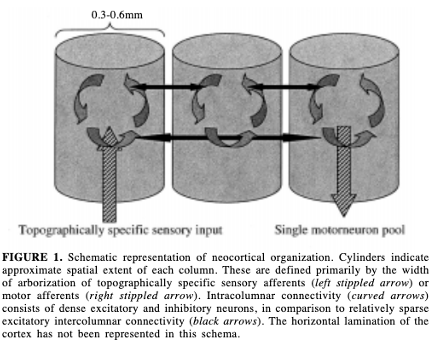

## The Synchronization Model

### Model for Single Cortical Column
The model for neuron synchronization used here comes from a paper by Breakspear et al. (2003), for which they use units of cortical columns.  It is based on a previous model by Larter et al. (1999) which was used to model epileptic seizures.  It should be noted that seizures are a result of a large number of neurons becoming synchronized and firing together, however, synchronization in general isn't always bad.  Many cognitive functions such as memory and learning processes are a result of neural synchronization.  For a single cortical column, the evolution equations governing the model are as follows:

$$ \frac{dV}{dt} = -(g_{Ca} + r_{NMDA}a_{ee}Q_{V})m_{Ca}(V-V_{Ca}) - (g_{Na}m_{Na} + a_{ee}Q_{V})(V−V_{Na}) - g_{K}W(V-V_{K}) - g_{L}(V-V_{L}) + a_{ie}ZQ_{Z} + a_{ne}I_{\delta} $$

$$ \frac{dZ}{dt} = b(a_{ni}I_{\delta} + a_{ei}VQ_{V}) $$

$$ \frac{dW}{dt} = \frac{\phi(m_{K}-W)}{\tau} $$

For the most part, the conjectured form of the equations were correct.  We see $V$ depends on the conductances and fraction of open ion channels, as well as the inhibitory input.  Also, $Z$ depends on $V$.  However, there are some additional terms.  First, in addition to the equations for $V$ and $Z$, there is a $W$.  This relates to the average number of open potassium channels.  It is similar to $m_{K}$, but due to the significance of potassium channels in the process of repolarizing the neuron, as well as the change from a single neuron to a cortical column, it's necessary to include an equation related to this variable.  Note it is included in place of $m_{ion}$ in the potassium term $g_{K}W\left(V-V_{K}\right)$.  The structure of the $W$ equation is due to the experimental observation that potassium channels relax exponentially.

The terms $Q_{V}$ and $Q_{Z}$ also appear in the equations.  These terms relate to the average firing rates of excitatory and inhibitory neurons, respectively, for a given cortical column.  They affect the frequency of firing of action potentials, and so are important to consider when using units of cortical columns.  In addition to the firing rates, there are numerous $a$ terms, which relate to the input strength of neurons.  That is, $a_{ie}$ refers to the strength between inhibitory to excitatory neurons, $a_{ei}$ the strength between excitatory to inhibitory neurons, and so on.  The terms $a_{ni}$ and $a_{ne}$ denote strength of external signals to the neurons.  Here, the external signal may be a current $I_{\delta}$, which can be zero.  This external current affects both the excitatory and inhibitory neurons.

While the structure of the $V$ equation may seem complicated, it may actually be derived from Ohm's Law.  Recall that the membrane may be thought of as a capacitor with capacitance $C$.  To find the potential difference across the capacitor, the equation for capacitance is $q=VC$ for a given charge $q$.  Since the time derivative of charge is $q$, this equation may be rewritten as $I = \frac{dq}{dt}=C\frac{dV}{dt}$.  Now, Ohm's law is commonly expressed as $V=IR$ for a given resistance $R$.  These equations can be solved for I and equated to give $C\frac{dV}{dt}=\frac{V}{R}=gV$.  Here, the conductance, $g=R^{-1}$, has replaced the resistance.  Taking $C=1$ mF gives $\frac{dV}{dt}=gV$, which resembles the structure of the $V$ equation.  Of course, this is a general derivation, and so the other terms need to be added in order to correctly model the given system, which here is a collection of neurons.

##### Example: Firing Rates
Above it was mentioned that the firing rates $Q_{V}$ and $Q_{Z}$ affect the frequency of firing.  The parameters are given explicitly by the following equations
$$Q_{V} = 0.5Q_{Vmax}\left(1+\tanh\left( \frac{V-V_{T}}{\delta_{V}} \right)\right)$$
$$Q_{Z} = 0.5Q_{Zmax}\left(1+\tanh\left( \frac{Z-Z_{T}}{\delta_{Z}} \right)\right)$$
Here $Q_{Vmax}$ and $Q_{Zmax}$ are the max firing rates.  Since $0.5\left(1+\tanh\left(x\right)\right)$ ranges from zero to one, these equations range from zero to the maximum firing rate of excitatory and inhibitory neurons respectively.  The $\delta$ terms in the denominator the the $\tanh$ argument are the variance of threshold potential for excitatory or inhibitory neurons.  This relates to the level at which the membrane potential potential must reach to fire an action potential.  For small $\delta$ values, the argument is large and so $\tanh$ is close to one.  This is because a small threshold variance implies the neurons in a cortical column fire at similar times.  Therefore, at a given voltage, the firing rate will be high.  On the other hand, large $\delta$ values implies the neurons fire at different voltage thresholds and so the firing rate will be low for any given potential because the argument of $\tanh$ is small, so the function is closer to zero.

Look at the following model and adjust the parameters for the maximum firing rates and threshold variances.  Do the spikes behave as you expect?  Note that neuron firing doesn't have to be periodic, but can also be chaotic.  You can also adjust the start time and end time points to see how the time series looks at different points in time for the case of chaotic firing (for more information on dynamics and chaos, see the references).

In [12]:
#end = 10000
def plot(qvmax,qzmax,dV,start,end):
    m = te.loada(model_three)
    m.gK = 2
    m.aEI = 2.0
    
    m.aEI = 0.1
    m.aEE = 0.5
    m.aIE = 0.5
    m.gNa = 0.0
    m.Idelta = 0.5

    m.QvMax = qvmax
    m.QzMax = qzmax
    m.dV = dV
    m.Idelta = 0.3
    
    start = start
    end = end
    s = m.simulate(0,3000,3000,['time','V','W','Z'])
    if end<start:
        msg = 'The end time is less than the start time.'
        raise ValueError(msg)
    if start>len(s) or end>len(s):
        msg = 'Choose a number less than {:1d}.  This is the duration of the simulation.'.format(len(s))
        raise ValueError(msg)
    else:
        s = m.simulate(0,3000,3000,['time','V','W','Z'])
        #plt.plot(s['time'][2000:2200],s['V'][2000:2200])
        plt.plot(s['time'][start:end],s['V'][start:end],label='V')
        plt.xlabel('time')
        plt.ylabel('potential')
        plt.legend()
        #plt.show()
        plt.show()
        
#length=len(s)
start = widgets.IntText(value=1000)
end = widgets.IntText(value=1200)
dv = widgets.FloatSlider(min=0.4,max=1,step=0.1,value=0.60)
qvm = widgets.FloatSlider(min=0.0,max=200,step=10,value=40)
qzm = widgets.FloatSlider(min=0.0,max=200,step=10,value=90)
interact(plot,qvmax=qvm,qzmax=qzm,dV=dv,start=start,end=end,continuous_update=False);
#interact(plot,qvmax=qvm,qzmax=qzm,dV=dv,continuous_update=False);

interactive(children=(FloatSlider(value=40.0, description='qvmax', max=200.0, step=10.0), FloatSlider(value=90.0, description='qzmax', max=200.0, step=10.0), FloatSlider(value=0.6, description='dV', max=1.0, min=0.4), IntText(value=1000, description='start'), IntText(value=1200, description='end'), Output()), _dom_classes=('widget-interact',))

##### Example: Phase Space
Another interesting description of the entire system can be found by considering the phase space of the system.  This is a concept from dynamical systems theory which allows one to study equilibria of the system, among other things.  In general, the phase space consists of all possible trajectories of a system depending on it's initial conditions, though isolated trajectories can also be examined.  The following phase space diagram shows the trajectory of a system with initial conditions $V_{0} = 0.0$, $W_{0} = 0.08$, and $Z_{0} = 0.0$.  Notice the default values present the system converging onto a stable periodic orbit.  In dynamical systems, this type of equilibrium is known as a limit cycle.  Ajust the scales and see if you can obtain another type of equilibrium, such as a stable spiral.  You can also adjust the angle of view by adjusting the angle slider.

In [11]:
from mpl_toolkits.mplot3d import axes3d

def plot(qvmax,qzmax,dV,angle):
    m = te.loada(model_three)
    
    angle = angle
    m.QvMax = qvmax
    m.QzMax = qzmax
    m.dV = dV
    m.Idelta = 0.3
    

    s = m.simulate(0,200,3000,['time','V','W','Z'])
    #plt.plot(s['time'][2000:2200],s['V'][2000:2200])

    # parametric plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # prepare arrays x, y, z
    x = s['V']
    y = s['W']
    z = s['Z']

    ax.plot(x, y, z)
    ax.set_title('dV = {:.2f}'.format(m.dV))
    ax.set_xlabel('V')
    ax.set_ylabel('W')
    ax.set_zlabel('Z')

    # rotate the axes and update
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
    plt.show()

    plt.show()

#length=len(s)
dv = widgets.FloatSlider(min=0.4,max=1,step=0.1,value=0.60)
qvm = widgets.FloatSlider(min=0.0,max=200,step=10,value=50)
qzm = widgets.FloatSlider(min=0.0,max=200,step=10,value=110)
angle = widgets.IntSlider(min=0,max=360,step=10,value=90)
interact(plot,qvmax=qvm,qzmax=qzm,dV=dv,angle=angle,continuous_update=False);
#interact(plot,qvmax=qvm,qzmax=qzm,dV=dv,continuous_update=False);

interactive(children=(FloatSlider(value=50.0, description='qvmax', max=200.0, step=10.0), FloatSlider(value=110.0, description='qzmax', max=200.0, step=10.0), FloatSlider(value=0.6, description='dV', max=1.0, min=0.4), IntSlider(value=90, description='angle', max=360, step=10), Output()), _dom_classes=('widget-interact',))

## Model for Coupled Columns
Now let's look at the model for multiple cortical columns.  In order for these columns to interact, or synchronize, a coupling term needs to be introduced.  This is done as follows: 

$$ \frac{dV^{i}}{dt} = -\left(g_{Ca} + \left(1-C\right)r_{NMDA}a_{ee}Q^{i}_{V} + Cr_{NMDA}a_{ee}\langle Q_{V}\rangle \right)m_{Ca}\left(V^{i}-V_{Ca}\right) - \left(g_{Na}m_{Na} + \left(1-C\right)a_{ee}Q^{i}_{V} + Ca_{ee}\langle Q_{V}\rangle \right)\left(V^{i}−V_{Na}\right) - g_{K}W^{i}\left(V^{i}-V_{K}\right) - g_{L}\left(V^{i}-V_{L}\right) + a_{ie}Z^{i}Q^{i}_{Z} + a_{ne}I_{\delta} $$

$$ \frac{dZ^{i}}{dt} = b(a_{ni}I_{\delta} + (1-C)a_{ei}V^{i}Q^{i}_{V}) + Ca_{ei}V^{i}\langle Q_{V}\rangle $$

$$ \frac{dW^{i}}{dt} = \frac{\phi(m_{K}-W^{i})}{\tau} $$

Here $i$ denotes the variables for the $i^{th}$ column and $\langle Q_{V}\rangle$ and $\langle Q_{Z}\rangle$ are the average firing rates of all cortical columns being considered, that is, $\langle Q_{V}\rangle = \frac{1}{N}\Sigma_{i=1}^{N}Q_{V}^{i}$ for $N$ cortical columns.  The coupling term is $C$.  Notice that when $C=0$, corresponding to uncoupled columns, the equations reduce to the equations for a single column as expected.  When $C=1$, the column-dependent terms, such as $r_{NMDA}a_{ee}Q^{i}_{V}$ or $a_{ee}Q^{i}_{V}$ vanish and each column shares the same equations, implying the columns are fully synchronized.

##### Example: Two Cortical Columns

Adjust the slider to see how the coupling term affects the dynamics of the system.  Again vary the threshold variances to see if different firing frequencies affect the synchronization.

In [13]:
model_couple = '''
    // equations 
    V1' = -(gCa + (1-C)*rNMDA*aEE*Qv1 + C*rNMDA*aEE*QvAvg)*mCa1*(V1-vCa) - (gNa*mNa1 + (1-C)*aEE*Qv1 + C*aEE*QvAvg)*(V1-vNa) - gK*W1*(V1-vK) - gL*(V1-vL) + aNE*Idelta + aIE*Z1*Qz1
    V2' = -(gCa + (1-C)*rNMDA*aEE*Qv2 + C*rNMDA*aEE*QvAvg)*mCa2*(V2-vCa) - (gNa*mNa2 + (1-C)*aEE*Qv2 + C*aEE*QvAvg)*(V2-vNa) - gK*W2*(V2-vK) - gL*(V2-vL) + aNE*Idelta + aIE*Z2*Qz2
    Z1' = b*(aNI*Idelta + (1-C)*aEI*V1*Qv1 + C*aEI*V1*QvAvg)
    Z2' = b*(aNI*Idelta + (1-C)*aEI*V2*Qv2 + C*aEI*V2*QvAvg)
    W1' = phi*(mK1 - W1)/tau
    W2' = phi*(mK2 - W2)/tau

//8
    // parameters 
    C = 0.1 ; // coupling term
    vCa = 1.0 ; // 1.0 // nerst potentials
    vNa = 0.53 ; // 0.53
    vL = -0.5 ; // -0.5
    vK = -0.7 ; // -0.7
    gCa = 1.1 ; // 1.1 // conductances
    gNa = 6.7 ; // 6.7
    gK = 2.0 ; // 2.0
    gL = 0.5 ; // 0.5
    deltaCa = 0.15 ;  // 0.15 // threshold variances
    deltaNa = 0.15 ; // 0.15
    deltaK = 0.3 ; // 0.3
    tCa = -0.01; // -0.01 // threshold potentials
    tNa = 0.3; // 0.3
    tK = 0.0; // 0.0
    mCa1 := 0.5*(1 + tanh((V1-tCa)/deltaCa)) ; // channel activations
    mCa2 := 0.5*(1 + tanh((V2-tCa)/deltaCa)) ;
    mNa1 := 0.5*(1 + tanh((V1-tNa)/deltaNa)) ;
    mNa2 := 0.5*(1 + tanh((V2-tNa)/deltaNa))
    mK1 := 0.5*(1 + tanh((V1-tK)/deltaK)) ; 
    mK2 := 0.5*(1 + tanh((V2-tK)/deltaK)) ; 
    dV1 = 0.5 ; // threshold variances
    dV2 = 0.54 ;
    dZ = 0.7 ;
    vT = 0.0 ; // threshold potentials
    zT = 0.0 ;
    QvMax = 50.0 ; // max firing rates
    QzMax = 0.9 ;
    Qv1 := 0.5*QvMax*(1 + tanh((V1-vT)/dV1)) ; // firing rate functions
    Qz1 := 0.5*QzMax*(1 + tanh((V1-zT)/dZ)) ;
    Qv2 := 0.5*QvMax*(1 + tanh((V2-vT)/dV2)) ; // firing rate functions
    Qz2 := 0.5*QzMax*(1 + tanh((V2-zT)/dZ)) ;
    QvAvg := (Qv1+Qv2)/2
    aEE = 0.4 ; //0.4 synaptic strength parameters
    aEI = 0.2 ; //2.0 // 0.31 gives limit cycle
    aIE = 1.0 ; //2.0
    aNE = 1.0 ; // 1.0
    aNI = 0.4 ; // 0.4
    phi = 0.7 ; // 0.7 // scaling factor
    b = -0.1 ; // 0.1 // scaling factor
    Idelta = 0.3 ; // 0.3 // input current
    tau = 1.0 ; // 1.0 // time constant
    rNMDA = 0.25 ; // 0.25 // AMPA:NMDA

    // initial conditions
    V1 = 0.0 ; 
    V2 = 0.0 ;
    Z1 = 0.08 ;
    Z2 = 0.08 ;
    W1 = 0.0 ;
    W2 = 0.0 ;
'''


In [14]:
def plot(C,dV1,dV2):
    m = te.loada(model_couple)
    m.QvMax = 2
    m.QzMax = 8
    m.C = C
    m.dV1 = dV1
    m.dV2 = dV2
    m.Idelta = 0.0
    s = m.simulate(0,100,3000,['time','V1','W1','Z1','V2','W2','Z2'])
    plt.plot(s['time'],s['V1'],label='$V_{1}$')
    plt.plot(s['time'],s['V2'],label='$V_{2}$')
    plt.xlabel('time')
    plt.ylabel('potential')
    plt.legend()
    plt.show()

c = widgets.FloatSlider(min=0.0,max=1.0,step=0.1)
dv1 = widgets.FloatSlider(min=0.4,max=1,step=0.05)
dv2 = widgets.FloatSlider(min=0.4,max=1,step=0.05)
interact(plot,C=c,dV1=dv1,dV2=dv2,continuous_update=False);

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0), FloatSlider(value=0.4, description='dV1', max=1.0, min=0.4, step=0.05), FloatSlider(value=0.4, description='dV2', max=1.0, min=0.4, step=0.05), Output()), _dom_classes=('widget-interact',))

In [15]:
m = te.loada(model_couple)
m.V1 = 0.2
m.W1 = 0.05
m.Z1 = 0.1
m.QvMax = 40
m.QzMax = 90
m.C = 0.1
m.dV1 = 0.5
m.dV2 = 0.5
#m.vT = 0.54
m.Idelta = 0.3
s = m.simulate(0,100,3000,['time','V1','W1','Z1','V2','W2','Z2'])
#plt.plot(s['time'],s['V1'],label='$V_{1}$')
#plt.plot(s['time'],s['V2'],label='$V_{2}$')
#plt.legend()
#plt.show()

The following is a plot of the logarithm of Euclidean distance between the potential of the two columns versus time.  You can see that it appears to be a decreasing linear which flattens out after some time, implying the columns synchronize exponentially with time.

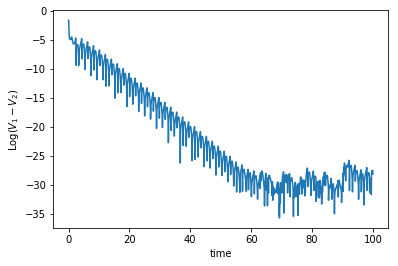

In [16]:
plt.plot(s['time'],np.log(np.abs(s['V2']-s['V1'])))
#plt.yscale('log')
plt.ylabel('Log$(V_{1}-V_{2})$')
plt.xlabel('time')
plt.show()

##### Example: Three Cortical Columns
Adjust the slider to see how a third cortical column affects the synchronization

In [18]:
### 
model_couple2 = '''
    // equations 
    V1' = -(gCa + (1-C)*rNMDA*aEE*Qv1 + C*rNMDA*aEE*QvAvg)*mCa1*(V1-vCa) - (gNa*mNa1 + (1-C)*aEE*Qv1 + C*aEE*QvAvg)*(V1-vNa) - gK*W1*(V1-vK) - gL*(V1-vL) + aNE*Idelta + aIE*Z1*Qz1
    V2' = -(gCa + (1-C)*rNMDA*aEE*Qv2 + C*rNMDA*aEE*QvAvg)*mCa2*(V2-vCa) - (gNa*mNa2 + (1-C)*aEE*Qv2 + C*aEE*QvAvg)*(V2-vNa) - gK*W2*(V2-vK) - gL*(V2-vL) + aNE*Idelta + aIE*Z2*Qz2
    V3' = -(gCa + (1-C)*rNMDA*aEE*Qv3 + C*rNMDA*aEE*QvAvg)*mCa3*(V3-vCa) - (gNa*mNa3 + (1-C)*aEE*Qv3 + C*aEE*QvAvg)*(V3-vNa) - gK*W3*(V3-vK) - gL*(V3-vL) + aNE*Idelta + aIE*Z3*Qz3
    Z1' = b*(aNI*Idelta + (1-C)*aEI*V1*Qv1 + C*aEI*V1*QvAvg)
    Z2' = b*(aNI*Idelta + (1-C)*aEI*V2*Qv2 + C*aEI*V2*QvAvg)
    Z3' = b*(aNI*Idelta + (1-C)*aEI*V3*Qv3 + C*aEI*V3*QvAvg)
    W1' = phi*(mK1 - W1)/tau
    W2' = phi*(mK2 - W2)/tau
    W3' = phi*(mK3 - W3)/tau

//8
    // parameters 
    C = 0.1 ; // coupling term
    vCa = 1.0 ; // 1.0 // nerst potentials
    vNa = 0.53 ; // 0.53
    vL = -0.5 ; // -0.5
    vK = -0.7 ; // -0.7
    gCa = 1.1 ; // 1.1 // conductances
    gNa = 6.7 ; // 6.7
    gK = 2.0 ; // 2.0
    gL = 0.5 ; // 0.5
    deltaCa = 0.15 ;  // 0.15 // threshold variances
    deltaNa = 0.15 ; // 0.15
    deltaK = 0.3 ; // 0.3
    tCa = -0.01; // -0.01 // threshold potentials
    tNa = 0.3; // 0.3
    tK = 0.0; // 0.0
    mCa1 := 0.5*(1 + tanh((V1-tCa)/deltaCa)) ; // channel activations
    mCa2 := 0.5*(1 + tanh((V2-tCa)/deltaCa)) ;
    mCa3 := 0.5*(1 + tanh((V3-tCa)/deltaCa)) ;
    mNa1 := 0.5*(1 + tanh((V1-tNa)/deltaNa)) ;
    mNa2 := 0.5*(1 + tanh((V2-tNa)/deltaNa)) ;
    mNa3 := 0.5*(1 + tanh((V3-tNa)/deltaNa)) ;
    mK1 := 0.5*(1 + tanh((V1-tK)/deltaK)) ; 
    mK2 := 0.5*(1 + tanh((V2-tK)/deltaK)) ; 
    mK3 := 0.5*(1 + tanh((V3-tK)/deltaK)) ; 
    dV1 = 0.5 ; // threshold variances
    dV2 = 0.5 ;
    dV3 = 0.5 ;
    dZ = 0.7 ;
    vT = 0.0 ; // threshold potentials
    zT = 0.0 ;
    QvMax = 2.5 ; // max firing rates
    QzMax = 5.5 ;
    Qv1 := 0.5*QvMax*(1 + tanh((V1-vT)/dV1)) ; // firing rate functions
    Qz1 := 0.5*QzMax*(1 + tanh((V1-zT)/dZ)) ;
    Qv2 := 0.5*QvMax*(1 + tanh((V2-vT)/dV2)) ; // firing rate functions
    Qz2 := 0.5*QzMax*(1 + tanh((V2-zT)/dZ)) ;
    Qv3 := 0.5*QvMax*(1 + tanh((V3-vT)/dV3)) ; // firing rate functions
    Qz3 := 0.5*QzMax*(1 + tanh((V3-zT)/dZ)) ;
    QvAvg := (Qv1+Qv2)/2
    aEE = 0.4 ; //0.4 synaptic strength parameters
    aEI = 2.0 ; //2.0 // 0.31 gives limit cycle
    aIE = 1.0 ; //2.0
    aNE = 1.0 ; // 1.0
    aNI = 0.4 ; // 0.4
    phi = 0.7 ; // 0.7 // scaling factor
    b = -0.1 ; // 0.1 // scaling factor
    Idelta = 0.3 ; // 0.3 // input current
    tau = 1.0 ; // 1.0 // time constant
    rNMDA = 0.25 ; // 0.25 // AMPA:NMDA

    // initial conditions
        // first column
        V1 = 0.1 ; 
        Z1 = 0.08 ;
        W1 = 0.0 ;
        
        // second column
        V2 = 0.0 ;
        Z2 = 0.04 ;
        W2 = 0.1 ;
        
        // third column
        V3 = 0.1 ;
        Z3 = 0.01 ;
        W3 = 0.3;
'''


In [19]:
def plot(C,dV1,dV2,dV3):
    m = te.loada(model_couple2)
    m.QvMax = 2
    m.QzMax = 8
    m.C = C
    m.dV1 = dV1
    m.dV2 = dV2
    m.dV3 = dV3
    #m.Idelta = 0.0
    s = m.simulate(0,100,3000,['time','V1','W1','Z1','V2','W2','Z2','V3','W3','Z3'])
    plt.plot(s['time'],s['V1'],label='$V_{1}$')
    plt.plot(s['time'],s['V2'],label='$V_{2}$')
    plt.plot(s['time'],s['V3'],label='$V_{3}$')
    plt.legend()
    plt.show()

c = widgets.FloatSlider(min=0.0,max=1.0,step=0.1)
dv1 = widgets.FloatSlider(min=0.4,max=1,step=0.05)
dv2 = widgets.FloatSlider(min=0.4,max=1,step=0.05)
dv3 = widgets.FloatSlider(min=0.4,max=1,step=0.05)
interact(plot,C=c,dV1=dv1,dV2=dv2,dV3=dv3,continuous_update=False);

interactive(children=(FloatSlider(value=0.0, description='C', max=1.0), FloatSlider(value=0.4, description='dV1', max=1.0, min=0.4, step=0.05), FloatSlider(value=0.4, description='dV2', max=1.0, min=0.4, step=0.05), FloatSlider(value=0.4, description='dV3', max=1.0, min=0.4, step=0.05), Output()), _dom_classes=('widget-interact',))

The columns still synchronize.  Recall how $\delta_{V}$ affects the firing rate: large values correspond to low firing rates while small values correspond to high firing rates.  Does this have an impact on how the synchronized dynamics behave?  Do high firing rates dominate?

## Conclusion
Neural synchronization plays a significan role in many cognitive functions.  This demonstration aimed to provide a walkthrough of the how neural synchronization might be modeled by considering the basic properties of neurons and building up some intuition behind the relevant variables and what they depend on, followed by some examples of a synchronization model based on the work of Breakspear and Terry.  However, this is certainly not comprehensive, and further information can be gained from the following additional material.

## Additional Material

#### Neuroscience and Biology
1. Kandel, E. R. (2005). Principles of Neuroscience. Appleton & Lange.
2. Alberts, Bruce. Molecular Biology of the Cell. Garland Science Taylor &amp; Francis, 2008. 
3. Gerstner, Wulfram. “Neuronal Dynamics Online Book.” Neuronal Dynamics Online Book, neuronaldynamics.epfl.ch/book.html. 

#### Dynamical Systems
1.	Strogatz, Steven. Nonlinear Dynamics and Chaos: with Applications to Physics, Biology, Chemistry, and Engineering. CRC Press, Taylor Et Francis Group, 2019. 
2. Izhikevich, Eugene M. Dynamical Systems in Neuroscience: the Geometry of Excitability and Bursting. MIT Press, 2014. 



## References
1.	Michael Breakspear, John R Terry, & Karl J Friston (2003) Modulation of excitatory synaptic coupling facilitates synchronization and complex dynamics in a biophysical model of neuronal dynamics, Network: Computation in Neural Systems, 14:4, 703-732, DOI: 10.1088/0954-898X_14_4_305.
2.	Larter R, Speelman B, Worth RM. A coupled ordinary differential equation lattice model for the simulation of epileptic seizures. Chaos. 1999 Sep; 9(3):795-804. doi: 10.1063/1.166453. PMID: 12779875.
3.	Michael Breakspear & John R Terry (2002) Nonlinear interdependence in neural systems: motivation, theory and relevance, International Journal of Neuroscience. 1121163–84.
4. Kandel, E. R. (2005). Principles of Neuroscience. Appleton & Lange.
